## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install additional dependencies
# !pip install numpy pandas pillow

# # Install ONNX packages
# !pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

# # Install TensorRT
# !pip install tensorrt

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import json
import os
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pil_utils.annotation import draw_bboxes

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import ONNX dependencies
import onnxruntime as ort # Import the ONNX Runtime
from onnxruntime.tools.symbolic_shape_infer import SymbolicShapeInference
from onnxruntime.quantization import CalibrationDataReader, CalibrationMethod, create_calibrator, write_calibration_table

# Import tensorrt
import tensorrt

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting the Directory Paths

In [3]:
# The name for the project
project_name = f"pytorch-yolox-object-detector"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2024-02-17_11-08-46")

pd.Series({
    "Project Directory:": project_dir, 
    "Dataset Directory:": dataset_dir, 
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-yolox-object-detector
Dataset Directory:,/mnt/980_1TB_2/Datasets
Checkpoint Directory:,pytorch-yolox-object-detector/2024-02-17_11-08-46


### Download a Font File

In [4]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Loading the Checkpoint Data

### Load the Colormap

In [5]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

### Set Model Checkpoint Information

In [6]:
# The onnx model path
onnx_file_path = list(checkpoint_dir.glob('*.onnx'))[0]

# Set max stride value for processing output
max_stride = 32

## Loading the Dataset

### Setting the Dataset Path

In [7]:
# Set the name of the dataset
dataset_name = 'hagrid-sample-30k-384p'

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

pd.Series({
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

Dataset Path:,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p


### Getting the Image and Annotation Folders

In [8]:
# Create a list of the items in the 'dataset_path' directory
dir_content = [item for item in dataset_path.iterdir() if item.is_dir()]

# Get the path of the 'ann_train_val' directory
annotation_dir = dataset_path/'ann_train_val'

# Remove the 'ann_train_val' directory from the list of items
dir_content.remove(annotation_dir)

# Get the path of the remaining directory, which is assumed to be the image directory
img_dir = dir_content[0]

# Print the path of the image directory
print(f"Image Directory: {img_dir}")

# Get a list of folders in the 'img_dir' directory
img_folder_paths = [folder for folder in img_dir.iterdir() if folder.is_dir()]

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths]})

Image Directory: /mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k


,Image Folder
0,train_val_call
1,train_val_dislike
2,train_val_fist
3,train_val_four
4,train_val_like
5,train_val_mute
6,train_val_ok
7,train_val_one
8,train_val_palm
9,train_val_peace


### Get Image File Paths

In [9]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for folder in img_folder_paths # Iterate through each image folder
    for file in get_img_files(folder) # Get a list of image files in each image folder
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 31833


,0
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00005c9c-3548-4a8f-9d0b-2dd4aff37fc9.jpg
0020a3db-82d8-47aa-8642-2715d4744db5,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/0020a3db-82d8-47aa-8642-2715d4744db5.jpg
004ac93f-0f7c-49a4-aadc-737e0ad4273c,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/004ac93f-0f7c-49a4-aadc-737e0ad4273c.jpg
006cac69-d3f0-47f9-aac9-38702d038ef1,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/006cac69-d3f0-47f9-aac9-38702d038ef1.jpg
00973fac-440e-4a56-b60c-2a06d5fb155d,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00973fac-440e-4a56-b60c-2a06d5fb155d.jpg


### Select Sample Images

In [10]:
random.seed(1234) # Set random seed for consistency 
img_keys = list(img_dict.keys())
img_keys_sample = random.sample(img_keys, len(img_keys)//10)

## Computing Quantization Parameters

### Implement a CalibrationDataReader

In [11]:
class CalibrationDataReaderCV(CalibrationDataReader):
    """
    A subclass of CalibrationDataReader specifically designed for handling
    image data for calibration in computer vision tasks. This reader loads,
    preprocesses, and provides images for model calibration.
    
    Attributes:
        img_dict (dict): A dictionary mapping image keys to image file paths.
        input_name (str): The name of the model input.
        max_stride (int): Maximum stride size, used to ensure input dimension compatibility.
        enum (iterator): An iterator over the image keys.
        target_sz (tuple): Target size to which images will be resized.
    """
    
    def __init__(self, img_keys, img_dict, target_sz, max_stride=32, input_name='input'):
        """
        Initializes a new instance of the CalibrationDataReaderCV class.
        
        Args:
            img_keys (iterable): An iterable of keys identifying images in `img_dict`.
            img_dict (dict): A dictionary mapping image keys to file paths.
            target_sz (tuple): The target size (width, height) to resize images to.
            max_stride (int, optional): Maximum stride for ensuring input dimension compatibility. Default is 32.
            input_name (str, optional): The name of the input node in the ONNX model. Default is 'input'.
        """
        super().__init__()  # Initialize the base class
        
        # Initialization of instance variables
        self._img_dict = img_dict
        self.input_name = input_name
        self.max_stride = max_stride
        self.enum = iter(img_keys)  # Create an iterator over the image keys
        self.target_sz = target_sz
        
    def get_next(self):
        """
        Retrieves, processes, and returns the next image in the sequence as a NumPy array suitable for model input.
        
        Returns:
            dict: A dictionary with a single key-value pair where the key is `input_name` and the value is the
                  preprocessed image as a NumPy array, or None if there are no more images.
        """
        
        img_key = next(self.enum, None)  # Get the next image key
        if not img_key:
            return None  # If there are no more keys, return None

        # Load the image from the filepath and convert to RGB
        filepath = self._img_dict[img_key]
        image = Image.open(filepath).convert('RGB')

        # Resize the image to the target size
        resized_img = resize_img(image, target_sz=self.target_sz, divisor=1)
        
        # Adjust dimensions to be multiples of max_stride
        input_dims = [dim - dim % self.max_stride for dim in resized_img.size]
        
        # Calculate offsets for cropping to maintain aspect ratio
        offsets = (np.array(resized_img.size) - np.array(input_dims)) / 2
        
        # Calculate the scale between original and resized images for potential use
        min_img_scale = min(image.size) / min(resized_img.size)
        max_img_scale = max(image.size) / max(resized_img.size)
        
        # Crop the resized image based on calculated offsets to fit model input requirements
        input_img = resized_img.crop(box=[*offsets, *(np.array(resized_img.size) - offsets)])

        # Convert the image to a NumPy array, normalize, and add a batch dimension
        input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None] / 255

        # Return the image in a dictionary under the specified input name
        return {self.input_name: input_tensor_np}

### Specify a Cache Folder

In [12]:
trt_cache_dir = checkpoint_dir/'trt_engine_cache'
trt_cache_dir.mkdir(parents=True, exist_ok=True)
trt_cache_dir

PosixPath('pytorch-yolox-object-detector/2024-02-17_11-08-46/trt_engine_cache')

### Compute Quantization Parameters

In [13]:
%%time

target_sz = 384

# Save path for temporary ONNX model used during calibration process
augmented_model_path = onnx_file_path.parent/f"{onnx_file_path.stem}-augmented.onnx"

try:
    # Create a calibrator object for the ONNX model.
    calibrator = create_calibrator(
        model=onnx_file_path, 
        op_types_to_calibrate=None, 
        augmented_model_path=augmented_model_path, 
        calibrate_method=CalibrationMethod.MinMax
    )

    # Set the execution providers for the calibrator.
    calibrator.set_execution_providers(["CUDAExecutionProvider", "CPUExecutionProvider"])

    # Initialize the custom CalibrationDataReader object
    calibration_data_reader = CalibrationDataReaderCV(img_keys=img_keys_sample, 
                                              img_dict=img_dict, 
                                              target_sz=target_sz, 
                                              max_stride=max_stride, 
                                              input_name=calibrator.model.graph.input[0].name)

    # Collect calibration data using the specified data reader.
    calibrator.collect_data(data_reader=calibration_data_reader)

    # Initialize an empty dictionary to hold the new compute range values.
    new_compute_range = {}

    # Compute data and update the compute range for each key in the calibrator's data.
    for k, v in calibrator.compute_data().data.items():
        # Extract the min and max values from the range_value.
        v1, v2 = v.range_value
        # Convert the min and max values to float and store them in the new_compute_range dictionary.
        new_compute_range[k] = (float(v1.item()), float(v2.item()))
        
    # Write the computed calibration table to the specified directory.
    write_calibration_table(new_compute_range, dir=str(trt_cache_dir))
    
except Exception as e:
    # Catch any exceptions that occur during the calibration process.
    print("An error occurred:", e)

finally:
    # Remove temporary ONNX file created during the calibration process
    if augmented_model_path.exists():
        augmented_model_path.unlink()

CPU times: user 46.4 s, sys: 4.72 s, total: 51.1 s
Wall time: 56.1 s


#### Verify Calibration Success

In [14]:
assert (trt_cache_dir/'calibration.flatbuffers').exists(), "Calibration Failed"

### Inspect TensorRT Cache Folder

In [15]:
# Print the content of the module folder as a Pandas DataFrame
pd.DataFrame([path.name for path in trt_cache_dir.iterdir()])

,0
0,calibration.cache
1,calibration.flatbuffers
2,calibration.json


## Performing Inference with TensorRT

### Add Path to TensorRT Library

In [16]:
# Define the new path to add
tensorrt_lib_path = Path(tensorrt.__path__[0]).parent/"tensorrt_libs"

# Add the path to the current session's environment variable
if 'LD_LIBRARY_PATH' in os.environ:
    if new_path not in os.environ['LD_LIBRARY_PATH']:
        os.environ['LD_LIBRARY_PATH'] += f':{tensorrt_lib_path}'
        print("The path was added to the current session's LD_LIBRARY_PATH.")
    else:
        print("The path is already in the current session's LD_LIBRARY_PATH.")
else:
    os.environ['LD_LIBRARY_PATH'] = str(tensorrt_lib_path)
    print("The path was initialized in the current session's LD_LIBRARY_PATH.")

# Print the content of the TensorRT library folder as a Pandas DataFrame
pd.DataFrame([path.name for path in tensorrt_lib_path.iterdir()])

The path was initialized in the current session's LD_LIBRARY_PATH.


,0
0,libnvinfer_plugin.so.8
1,libnvonnxparser.so.8
2,__pycache__
3,libnvparsers.so.8
4,libnvinfer_builder_resource.so.8.6.1
5,libnvinfer.so.8
6,__init__.py


### Create an Inference Session

In [17]:
ort.get_available_providers()

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

In [18]:
providers = [
    ('TensorrtExecutionProvider', {
        'device_id': 0, # The device ID
        'trt_max_workspace_size': 4e9, # Maximum workspace size for TensorRT engine (1e9 ≈ 1GB)
        'trt_engine_cache_enable': True, # Enable TensorRT engine caching
        'trt_engine_cache_path': str(trt_cache_dir), # Path for TensorRT engine, profile files, and INT8 calibration table
        'trt_int8_enable': True, # Enable INT8 mode in TensorRT
        'trt_int8_calibration_table_name': 'calibration.flatbuffers', # INT8 calibration table file for non-QDQ models in INT8 mode
    })
]

sess_opt = ort.SessionOptions()

# Load the model and create an InferenceSession
session = ort.InferenceSession(onnx_file_path, sess_options=sess_opt, providers=providers)

2024-03-22 17:09:54.301770534 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-03-23 00:09:54 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
2024-03-22 17:09:54.301796642 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-03-23 00:09:54 WARNING] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
2024-03-22 17:09:54.314259221 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-03-23 00:09:54 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
2024-03-22 17:09:54.314276932 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-03-23 00:09:54 WARNING] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped


### Define Utility Functions

#### Define a function to generate the output grids

In [19]:
def generate_output_grids_np(height, width, strides=[8,16,32]):
    """
    Generate a numpy array containing grid coordinates and strides for a given height and width.

    Args:
        height (int): The height of the image.
        width (int): The width of the image.

    Returns:
        np.ndarray: A numpy array containing grid coordinates and strides.
    """

    all_coordinates = []

    for stride in strides:
        # Calculate the grid height and width
        grid_height = height // stride
        grid_width = width // stride

        # Generate grid coordinates
        g1, g0 = np.meshgrid(np.arange(grid_height), np.arange(grid_width), indexing='ij')

        # Create an array of strides
        s = np.full((grid_height, grid_width), stride)

        # Stack the coordinates along with the stride
        coordinates = np.stack((g0.flatten(), g1.flatten(), s.flatten()), axis=-1)

        # Append to the list
        all_coordinates.append(coordinates)

    # Concatenate all arrays in the list along the first dimension
    output_grids = np.concatenate(all_coordinates, axis=0)

    return output_grids

#### Define a function to calculate bounding boxes and probabilities

In [20]:
def calculate_boxes_and_probs(model_output:np.ndarray, output_grids:np.ndarray) -> np.ndarray:
    """
    Calculate the bounding boxes and their probabilities.

    Parameters:
    model_output (numpy.ndarray): The output of the model.
    output_grids (numpy.ndarray): The output grids.

    Returns:
    numpy.ndarray: The array containing the bounding box coordinates, class labels, and maximum probabilities.
    """
    # Calculate the bounding box coordinates
    box_centroids = (model_output[..., :2] + output_grids[..., :2]) * output_grids[..., 2:]
    box_sizes = np.exp(model_output[..., 2:4]) * output_grids[..., 2:]

    x0, y0 = [t.squeeze(axis=2) for t in np.split(box_centroids - box_sizes / 2, 2, axis=2)]
    w, h = [t.squeeze(axis=2) for t in np.split(box_sizes, 2, axis=2)]

    # Calculate the probabilities for each class
    box_objectness = model_output[..., 4]
    box_cls_scores = model_output[..., 5:]
    box_probs = np.expand_dims(box_objectness, -1) * box_cls_scores

    # Get the maximum probability and corresponding class for each proposal
    max_probs = np.max(box_probs, axis=-1)
    labels = np.argmax(box_probs, axis=-1)

    return np.array([x0, y0, w, h, labels, max_probs]).transpose((1, 2, 0))

#### Define a function to calculate the intersection-over-union

In [21]:
def calc_iou(proposals:np.ndarray) -> np.ndarray:
    """
    Calculates the Intersection over Union (IoU) for all pairs of bounding boxes (x,y,w,h) in 'proposals'.

    The IoU is a measure of overlap between two bounding boxes. It is calculated as the area of
    intersection divided by the area of union of the two boxes.

    Parameters:
    proposals (2D np.array): A NumPy array of bounding boxes, where each box is an array [x, y, width, height].

    Returns:
    iou (2D np.array): The IoU matrix where each element i,j represents the IoU of boxes i and j.
    """

    # Calculate coordinates for the intersection rectangles
    x1 = np.maximum(proposals[:, 0], proposals[:, 0][:, None])
    y1 = np.maximum(proposals[:, 1], proposals[:, 1][:, None])
    x2 = np.minimum(proposals[:, 0] + proposals[:, 2], (proposals[:, 0] + proposals[:, 2])[:, None])
    y2 = np.minimum(proposals[:, 1] + proposals[:, 3], (proposals[:, 1] + proposals[:, 3])[:, None])
    
    # Calculate intersection areas
    intersections = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    # Calculate union areas
    areas = proposals[:, 2] * proposals[:, 3]
    unions = areas[:, None] + areas - intersections

    # Calculate IoUs
    iou = intersections / unions

    # Return the iou matrix
    return iou

#### Define a function to filter bounding box proposals using Non-Maximum Suppression

In [22]:
def nms_sorted_boxes(iou:np.ndarray, iou_thresh:float=0.45) -> np.ndarray:
    """
    Applies non-maximum suppression (NMS) to sorted bounding boxes.

    It suppresses boxes that have high overlap (as defined by the IoU threshold) with a box that 
    has a higher score.

    Parameters:
    iou (np.ndarray): An IoU matrix where each element i,j represents the IoU of boxes i and j.
    iou_thresh (float): The IoU threshold for suppression. Boxes with IoU > iou_thresh are suppressed.

    Returns:
    keep (np.ndarray): The indices of the boxes to keep after applying NMS.
    """

    # Create a boolean mask to keep track of boxes
    mask = np.ones(iou.shape[0], dtype=bool)

    # Apply non-max suppression
    for i in range(iou.shape[0]):
        if mask[i]:
            # Suppress boxes with higher index and IoU > threshold
            mask[(iou[i] > iou_thresh) & (np.arange(iou.shape[0]) > i)] = False

    # Return the indices of the boxes to keep
    return np.arange(iou.shape[0])[mask]

### Select a Test Image

The file ./pexels-2769554-man-doing-rock-and-roll-sign.jpg already exists and overwrite is set to False.


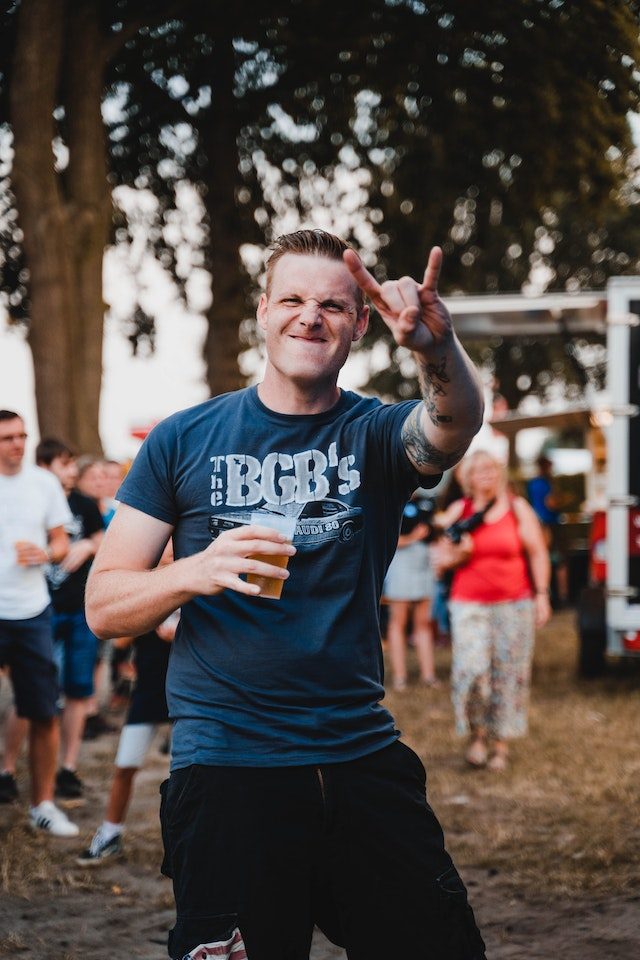

Test Image Size:,"(640, 960)"


In [23]:
test_img_name = "pexels-2769554-man-doing-rock-and-roll-sign.jpg"
test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
display(test_img)

pd.Series({
    "Test Image Size:": test_img.size, 
}).to_frame().style.hide(axis='columns')

### Prepare the Test Image

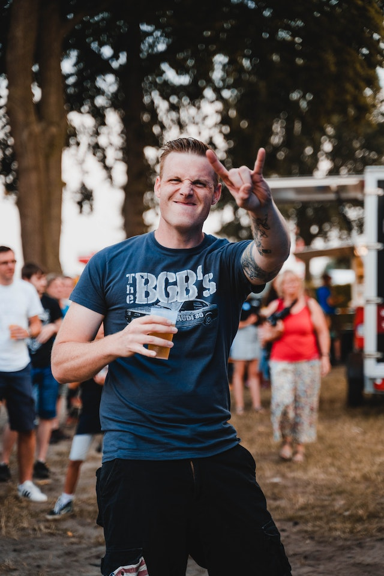

Resized Image Size:,"(384, 576)"
Input Dims:,"[384, 576]"
Offsets:,[0. 0.]
Min Image Scale:,1.666667
Input Image Size:,"(384, 576)"


In [24]:
# Set the input image size
test_sz = 384

# Resize image without cropping to multiple of the max stride
resized_img = resize_img(test_img, target_sz=test_sz, divisor=1)

# Calculating the input dimensions that multiples of the max stride
input_dims = [dim - dim % max_stride for dim in resized_img.size]

# Calculate the offsets from the resized image dimensions to the input dimensions
offsets = (np.array(resized_img.size) - input_dims)/2

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(resized_img.size)

# Crop the resized image to the input dimensions
input_img = resized_img.crop(box=[*offsets, *resized_img.size-offsets])

display(input_img)

pd.Series({
    "Resized Image Size:": resized_img.size,
    "Input Dims:": input_dims,
    "Offsets:": offsets,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

### Prepare the Input Tensor

In [25]:
# Convert the existing input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

### Build TensorRT Engine

In [26]:
%%time
# Perform a single inference run to build the TensorRT engine for the current input dimensions
session.run(None, {"input": input_tensor_np});

2024-03-22 17:09:54.595457792 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-03-23 00:09:54 WARNING] Calibrator is not being used. Users must provide dynamic range for all tensors that are not Int32 or Bool.


CPU times: user 1min 18s, sys: 5.58 s, total: 1min 24s
Wall time: 1min 34s


### Inspect TensorRT Cache Folder

In [27]:
# Print the content of the module folder as a Pandas DataFrame
pd.DataFrame([path.name for path in trt_cache_dir.iterdir()])

,0
0,calibration.cache
1,calibration.flatbuffers
2,calibration.json
3,TensorrtExecutionProvider_TRTKernel_graph_main_graph_12802227604276161730_0_0_int8_sm89.engine
4,TensorrtExecutionProvider_TRTKernel_graph_main_graph_12802227604276161730_0_0_int8_sm89.profile


### Benchmark Quantized Model

In [28]:
%%timeit
session.run(None, {"input": input_tensor_np})

841 µs ± 8.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Compute the Predictions

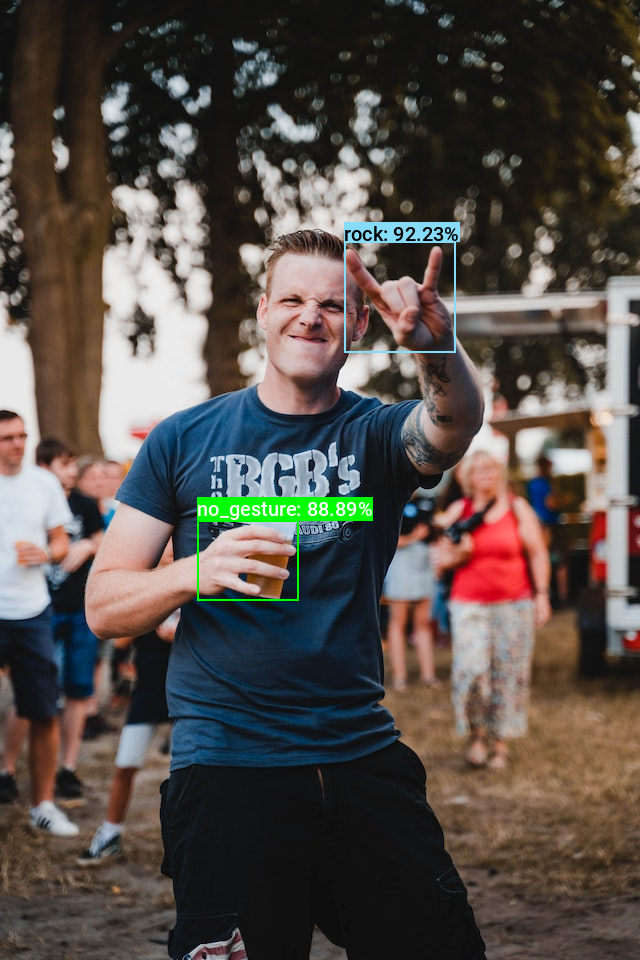

Predicted BBoxes:,"['rock:[344.559 241.291 111.415 111.701]', 'no_gesture:[197.462 520.354 101.168 79.862]']"
Confidence Scores:,"['rock: 92.23%', 'no_gesture: 88.89%']"


In [29]:
# Run inference
outputs = session.run(None, {"input": input_tensor_np})[0]

# Process the model output
outputs = calculate_boxes_and_probs(outputs, generate_output_grids_np(*input_tensor_np.shape[2:4]))

bbox_conf_thresh = 0.45
iou_thresh = 0.45

# Filter the proposals based on the confidence threshold
max_probs = outputs[:, : ,-1]
mask = max_probs > bbox_conf_thresh
proposals = outputs[mask]

# Sort the proposals by probability in descending order
proposals = proposals[proposals[..., -1].argsort()][::-1]

# Apply non-max suppression to the proposals with the specified threshold
proposal_indices = nms_sorted_boxes(calc_iou(proposals[:, :-2]), iou_thresh)
proposals = proposals[proposal_indices]

bbox_list = (proposals[:,:4]+[*offsets, 0, 0])*min_img_scale
label_list = [class_names[int(idx)] for idx in proposals[:,4]]
probs_list = proposals[:,5]

annotated_img = draw_bboxes(
    image=test_img, 
    boxes=bbox_list, 
    labels=label_list,
    probs=probs_list,
    colors=[int_colors[class_names.index(i)] for i in label_list], 
    font=font_file,
)

display(annotated_img)

# Print the prediction data as a Pandas Series for easy formatting
pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(label_list, bbox_list.round(decimals=3))],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(label_list, probs_list)]
}).to_frame().style.hide(axis='columns')